In [2]:
%matplotlib inline

import multiprocessing
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from itertools import islice

In [3]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from pytorch_lightning.loggers import CSVLogger
from datasets import load_dataset

from estimator import LagHyenaEstimator

[2023-07-09 10:41:12,317] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [4]:
dataset = get_dataset("electricity")

In [5]:
estimator = LagHyenaEstimator(
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*6,
        
        scaling="std",
            
        batch_size=256,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(accelerator="gpu", precision="bf16-mixed", max_epochs=50),
    )

In [6]:
predictor = estimator.train(
        training_data=dataset.train,
        shuffle_buffer_length=1024,
        cache_data=True,
    )

Authorization required, but no authorization protocol specified
Using bfloat16 Automatic Mixed Precision (AMP)
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing lo

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 5.85834 (best 5.85834), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-hyena/lightning_logs/version_0/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 5.48885 (best 5.48885), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-hyena/lightning_logs/version_0/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 5.40660 (best 5.40660), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-hyena/lightning_logs/version_0/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached 5.39881 (best 5.39881), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-hyena/lightning_logs/version_0/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached 5.34346 (best 5.34346), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-hyena/lightning_logs/vers

In [7]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [8]:
forecasts = list(forecast_it)

In [9]:
tss = list(ts_it)

In [10]:
# num_workers is limited to 10 if cpu has more cores
num_workers = min(multiprocessing.cpu_count(), 10)

evaluator = Evaluator(num_workers=num_workers)

In [11]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))


Running evaluation: 2247it [00:00, 33932.08it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eva

In [12]:
agg_metrics

{'MSE': 1616348.9693764935,
 'abs_error': 8126224.806433607,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.6980736197179844,
 'MAPE': 0.09819207674197261,
 'sMAPE': 0.10150725353343952,
 'MSIS': 7.087474157779949,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 3370212.7606336046,
 'Coverage[0.1]': 0.18240987983978638,
 'QuantileLoss[0.2]': 5333475.863171123,
 'Coverage[0.2]': 0.277369826435247,
 'QuantileLoss[0.3]': 6690672.275897219,
 'Coverage[0.3]': 0.35106067349058,
 'QuantileLoss[0.4]': 7601358.001463546,
 'Coverage[0.4]': 0.41547989912475897,
 'QuantileLoss[0.5]': 8126224.786909867,
 'Coverage[0.5]': 0.4804925085298916,
 'QuantileLoss[0.6]': 8322949.662872441,
 'Coverage[0.6]': 0.5386255748405281,
 'QuantileLoss[0.7]': 8099876.436319996,
 'Coverage[0.7]': 0.604064678831034,
 'QuantileLoss[0.8]': 7362424.878155968,
 'Coverage[0.8]': 0.6776442664293131,
 'QuantileLoss[0.9]': 5789441.404007915,
 'Cov

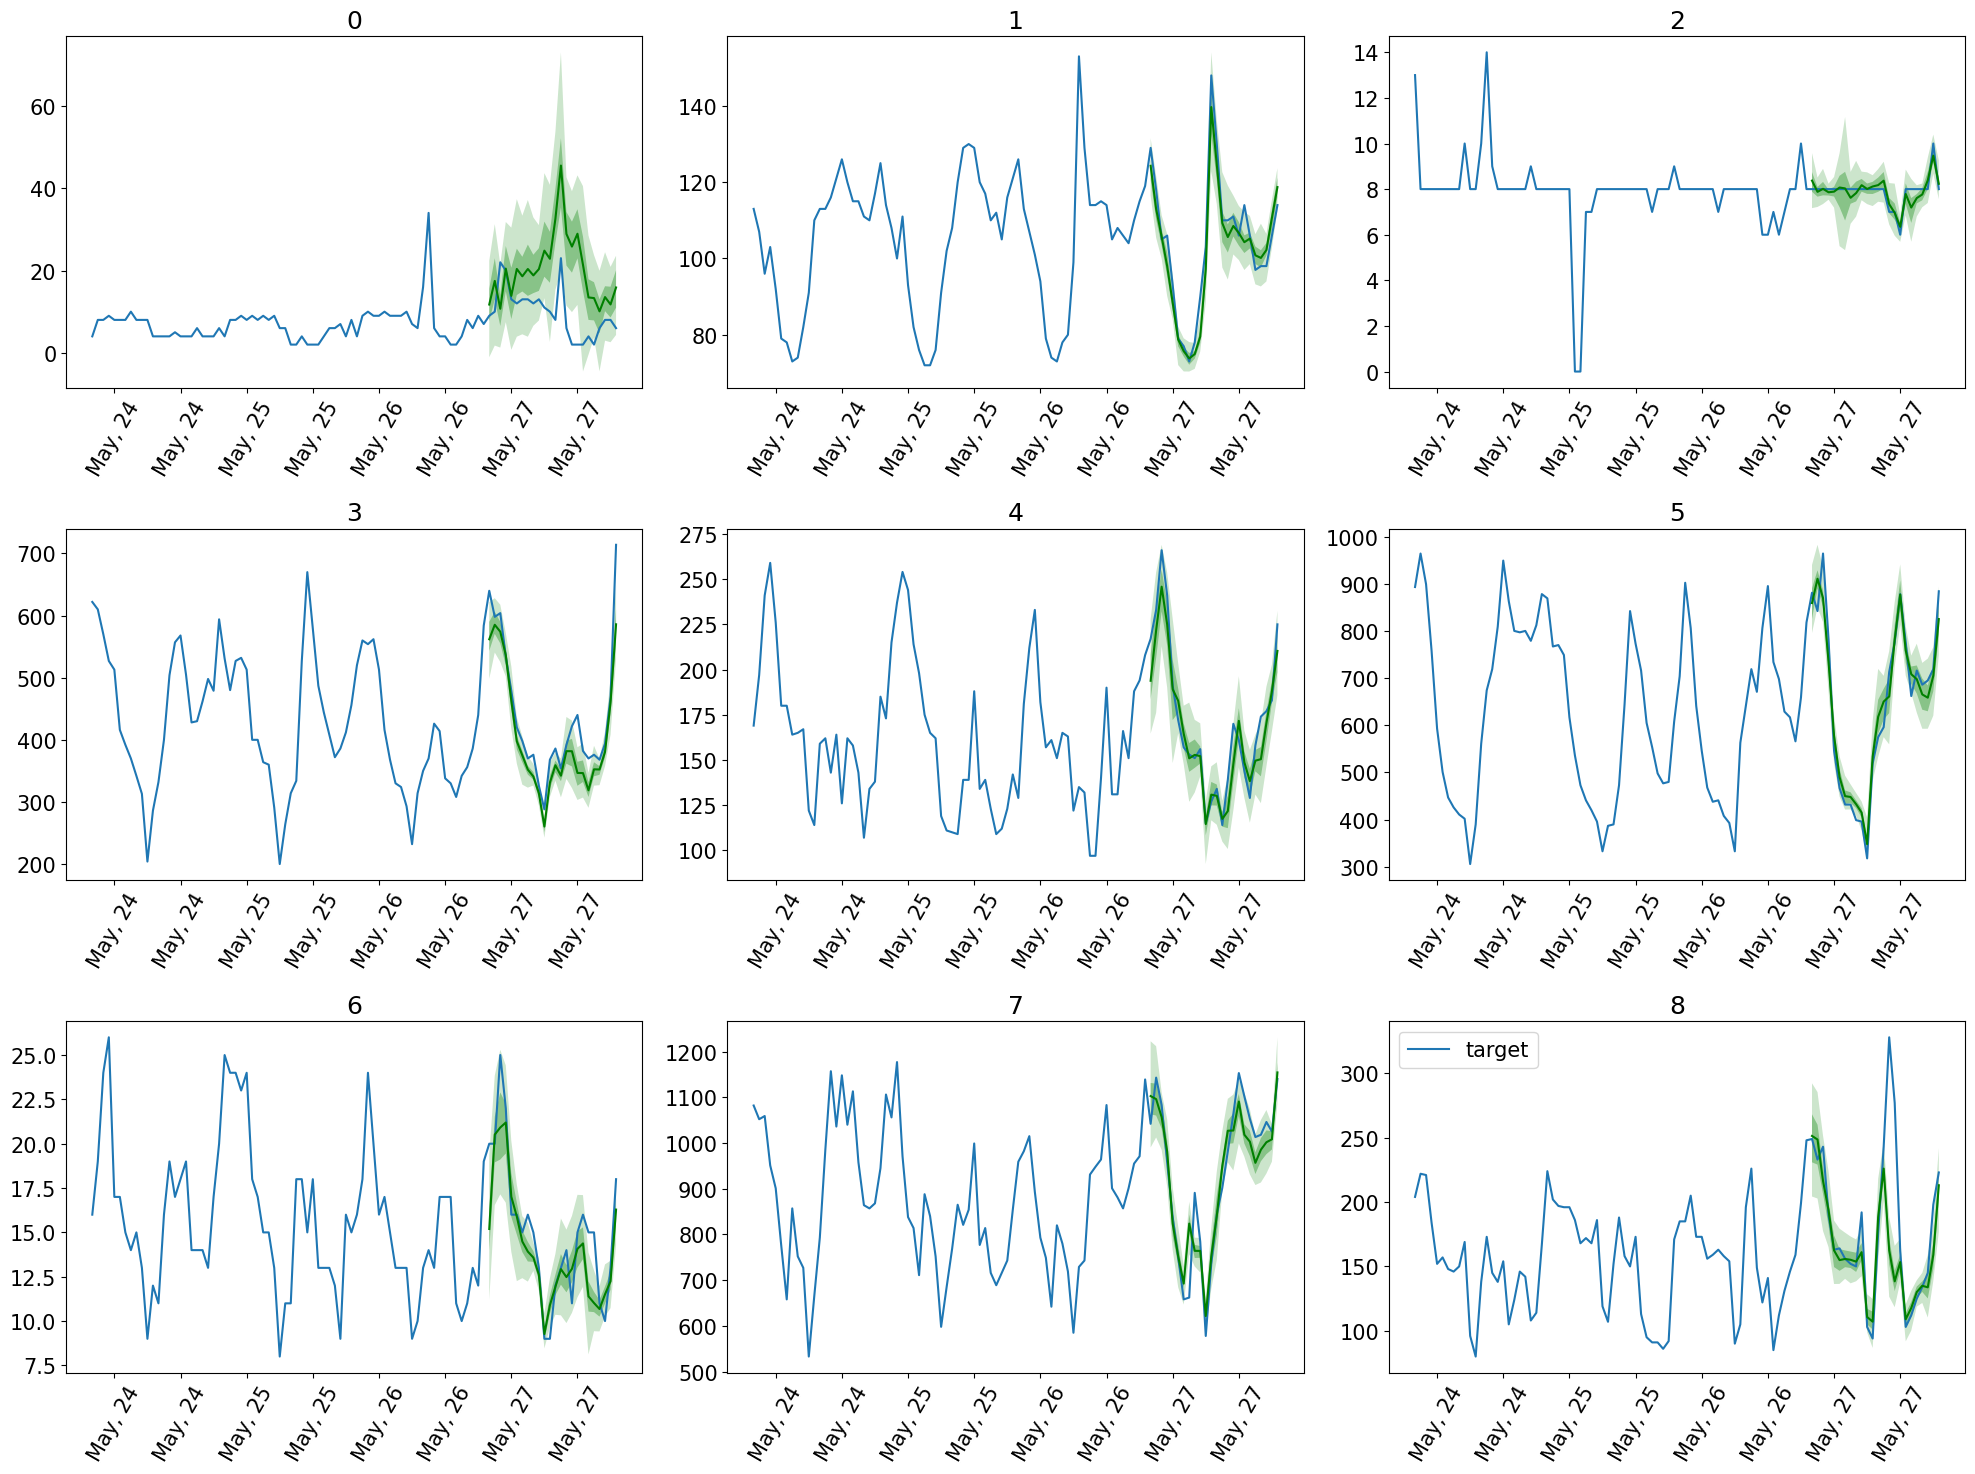

In [13]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()